### 1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

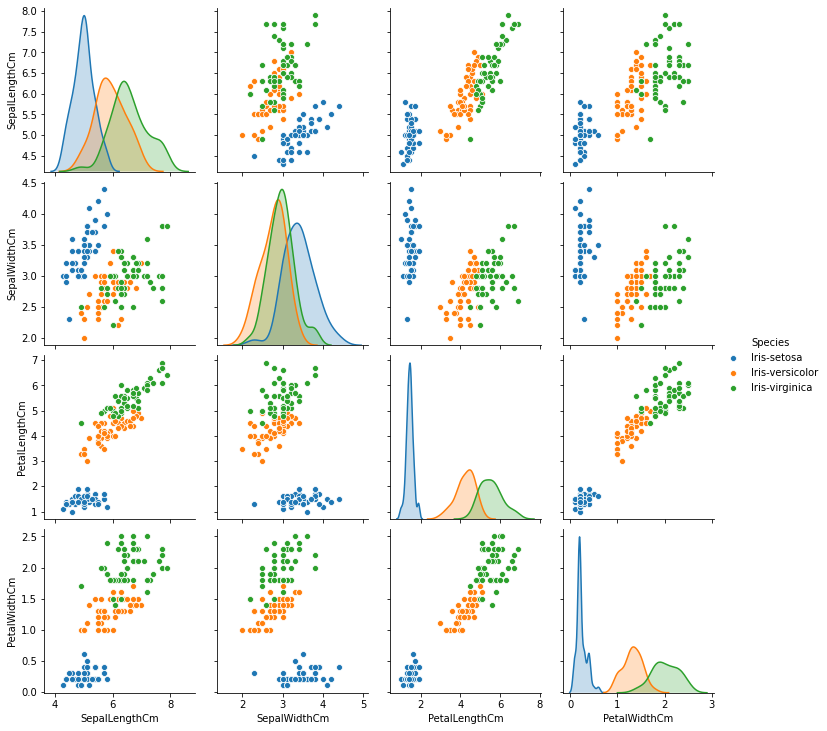

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [4]:
iris_data.head(3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0


In [5]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 7.2 KB


In [6]:
iris_data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667,1.000000
std,43.445368,0.828066,0.433594,1.764420,0.763161,0.819232
min,1.000000,4.300000,2.000000,1.000000,0.100000,0.000000
25%,38.250000,5.100000,2.800000,1.600000,0.300000,0.000000
50%,75.500000,5.800000,3.000000,4.350000,1.300000,1.000000
75%,112.750000,6.400000,3.300000,5.100000,1.800000,2.000000
max,150.000000,7.900000,4.400000,6.900000,2.500000,2.000000


In [7]:
### Шаг 3. Обученние нейронной сети


def train_network(X_train, y_train, neuron_numb, n, iterations=3000):

    """
    :param X_train:
    :param y_train:
    :param neuron_numb:
    :param n:
    :param iterations: default 3000
    :return: errors, accuracy, layer2, w0, w1
    """
    
  # присваевание случайных весов (стартовые значения)
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, neuron_numb выходов
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - neuron_numb входов, 3 выхода

  # массив для ошибок, чтобы потом построить график
    errors = []

  # процесс обучения
    for i in range(iterations):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)
        # коррекция
        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
    
    return errors, accuracy, layer2, w0, w1


In [8]:
### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения

def plot(accuracy, layer2, flag:str, errors=0):

    """
    :param accuracy:
    :param layer2:
    :param flag: 'train' or 'test'
    :param errors: default 0
    :return: 
    """
    
    if flag == 'train':
        plt.figure(figsize = (16,5))
        plt.plot(errors)
        plt.xlabel('Обучение')
        plt.ylabel('Ошибка')
        plt.show() # расскоментируйте, чтобы посмотреть 

        N = 50
        plt.figure(figsize = (16,5))
        plt.plot(layer2[:N,1], 'r',label = 'Y new')
        plt.plot(y_train[:N,1],'g', label = 'Y train')
        plt.xlabel('№ примера')
        plt.ylabel('выход сети и целевой')
        plt.legend( )
        plt.show() # расскоментируйте, чтобы посмотреть 

        print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")

    elif flag == 'test':
        layer2_t = layer2
        N = 50
        plt.figure(figsize = (16,5))
        plt.plot(layer2_t[:N,1], 'r',label = 'Y new')
        plt.plot(y_test[:N,1],'g', label = 'Y train')
        plt.xlabel('№ примера')
        plt.ylabel('выход сети и целевой')
        plt.legend( )
        plt.show() # расскоментируйте, чтобы посмотреть

        print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

    else:
        print('Неверное значение переменной flag. Переменная flag можнт принимать значения "train" или "test"')

In [9]:
def test_data(X_test, y_test, w0_res, w1_res):
    
    """
    :param X_test:
    :param y_test:
    :param w0_res:
    :param w1_res:
    :return: accuracy_t, layer2_t
    """
    
    # прямое распространение(feed forward)
    layer0_t = X_test
    layer1_t = sigmoid(np.dot(layer0_t, w0_res))
    layer2_t = sigmoid(np.dot(layer1_t, w1_res))
    layer2_error_t = y_test - layer2_t

    # метрика модели
    error_t = np.mean(np.abs(layer2_error_t))
    accuracy_t = (1 - error_t) * 100

    return accuracy_t, layer2_t

### Испытание 1. Число нейронов скрытого слоя - 5, скорость обучения - 0.1

In [10]:
# число нейронов скрытого слоя
neuron_numb = 5

# скорость обучения (learning rate)
n = 0.1

In [11]:
errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, neuron_numb, n)

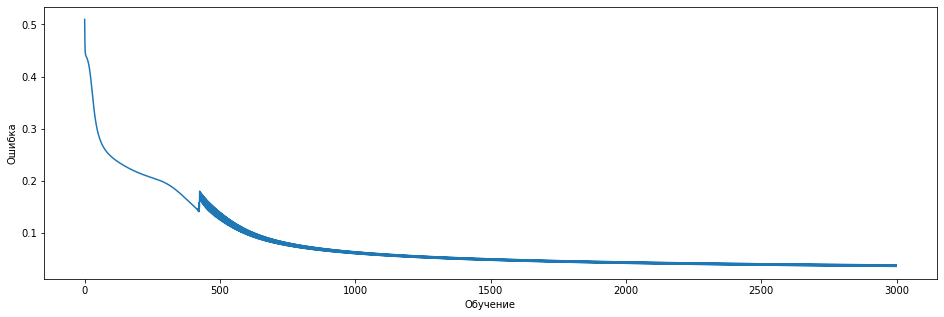

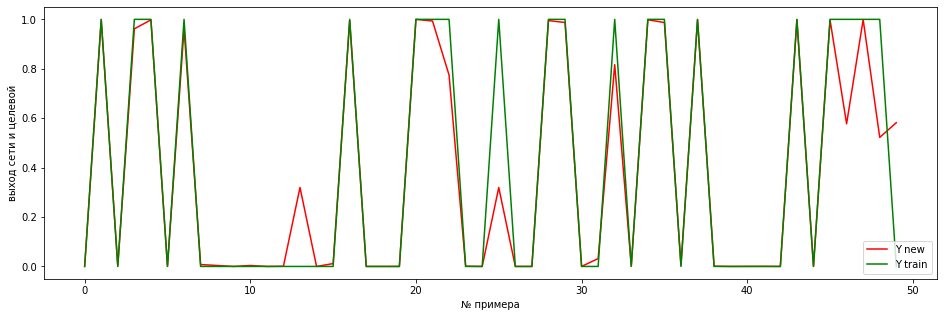

Аккуратность нейронной сети 96.06%


In [12]:
plot(accurasy_train, layer2, 'train', errors_train)

### Проверка результатов на test

In [13]:
accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)

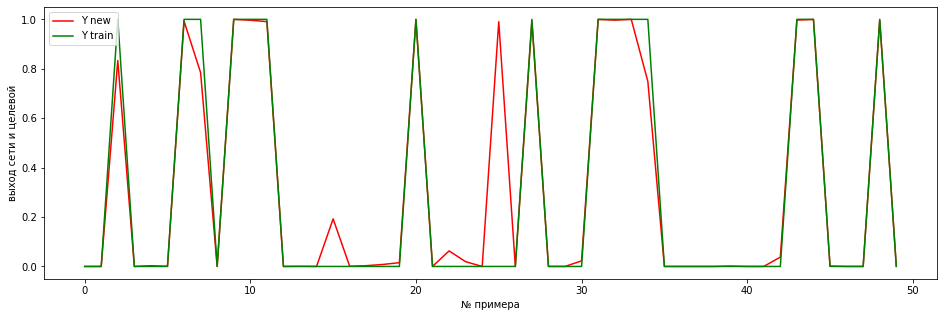

Аккуратность нейронной сети на тесте 96.69%


In [14]:
plot(accuracy_t, layer2_t, 'test')

### Испытание 2. Число нейронов скрытого слоя - 15, скорость обучения - 0.1

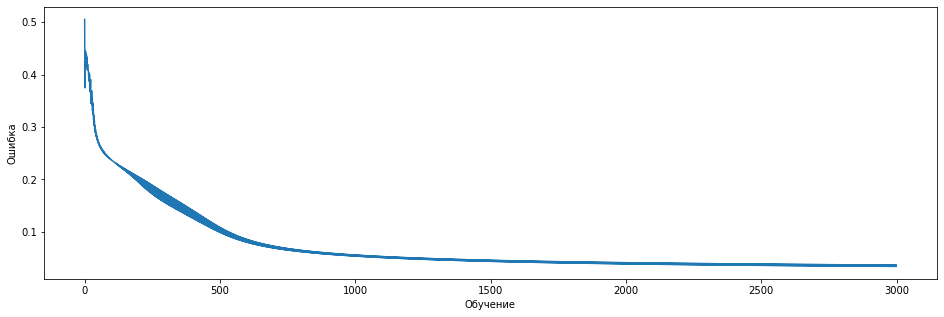

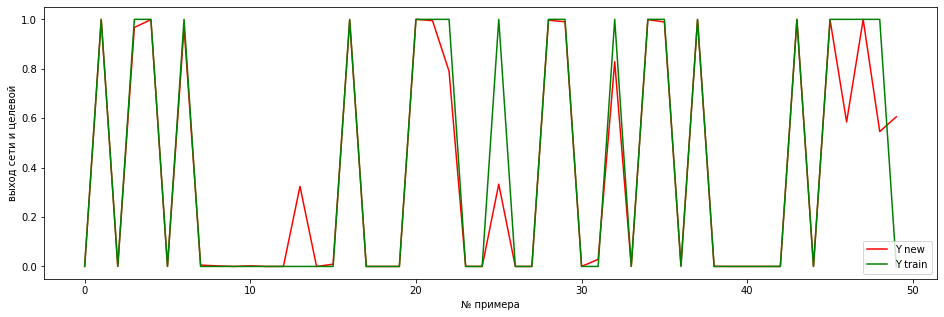

Аккуратность нейронной сети 96.33%


In [15]:
errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, 15, 0.1)
plot(accurasy_train, layer2, 'train', errors_train)

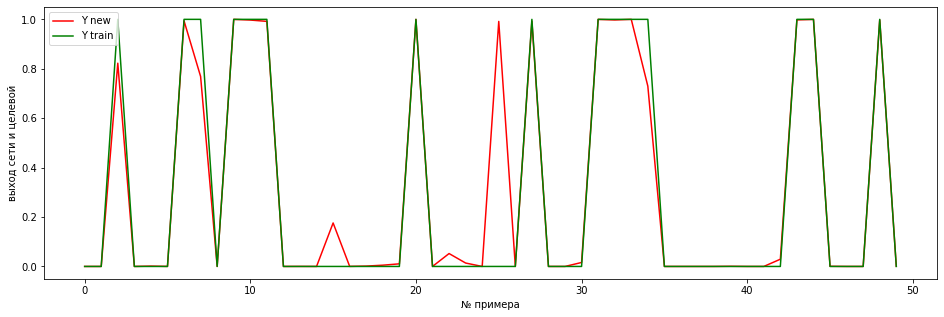

Аккуратность нейронной сети на тесте 96.9%


In [16]:
### Проверка на test
accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)
plot(accuracy_t, layer2_t, 'test')

### Испытание 3. Число нейронов скрытого слоя - 5, скорость обучения - 0.01

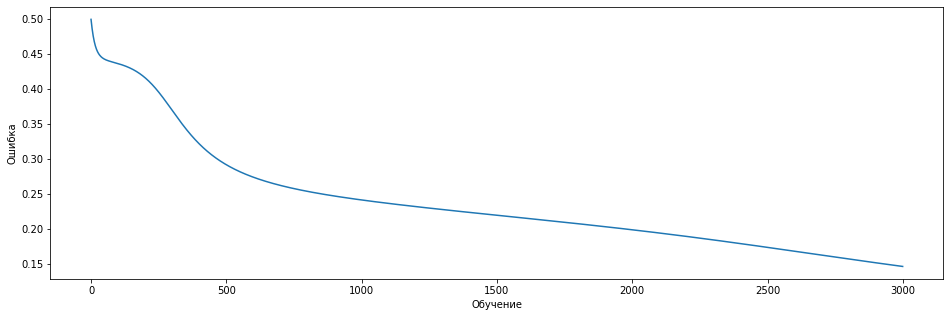

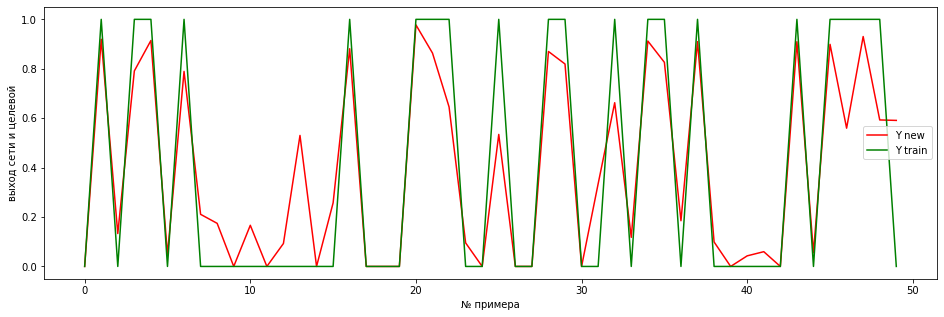

Аккуратность нейронной сети 85.32%


In [18]:
errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, 5, 0.01)
plot(accurasy_train, layer2, 'train', errors_train)

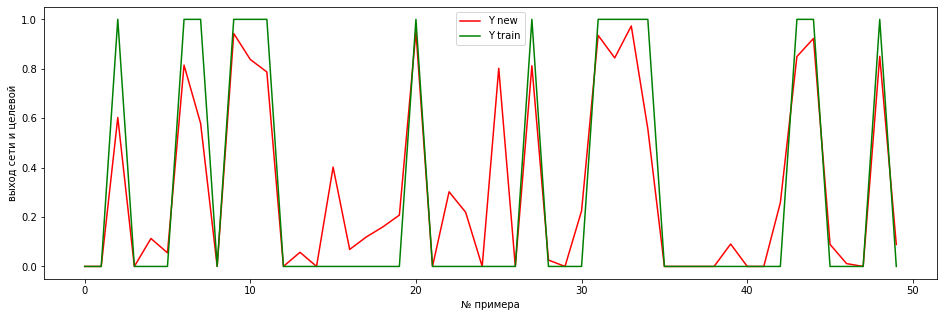

Аккуратность нейронной сети на тесте 85.45%


In [19]:
### Проверка на test
accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)
plot(accuracy_t, layer2_t, 'test')

### Видно, что при увеличении количества нейронов скрытого слоя, результаты обучения улучшаются. При уменьшении скорости обучения результаты становятся хуже.

### 2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

### Проведем расчеты для множества примеров, чтобы лучше понять, как меняестся accurasy, когда мы изменяем парамтры обучения.

### Сначала рассмотрим число скрытых нейронов, возьмем значения от 5 до 50 с шагом 5.

In [20]:
neuron_numb = np.arange(5, 51, 5)
n = 0.1
accurasy = []

for n_numb in neuron_numb:
    errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, n_numb, n)
#     plot(accurasy_train, layer2, 'train', errors_train)
    accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)
#     plot(accuracy_t, layer2_t, 'test')
    accurasy.append([n_numb, accurasy_train, accuracy_t])

data = pd.DataFrame(accurasy, columns=['n_numb', 'accurasy_train', 'accuracy_t'])    

In [21]:
data

,n_numb,accurasy_train,accuracy_t
0,5,96.187415,96.812332
1,10,96.323806,96.930075
2,15,96.320116,96.917477
3,20,96.301019,96.867979
4,25,96.581485,96.158827
5,30,96.630771,96.216513
6,35,96.642030,96.216055
7,40,96.589113,96.157613
8,45,96.522403,96.108962
9,50,96.558752,96.166387


### Видим, что с изменением neuron_numb результаты изменяются незначительно.

### Далее рассмотрим скорость обучения при двух вариантах neuron_numb - 5 и 30.

In [22]:
neuron_numb = 5
n = [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2]
accurasy_n = []

for num in n:
    errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, neuron_numb, num)
#     plot(accurasy_train, layer2, 'train', errors_train)
    accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)
#     plot(accuracy_t, layer2_t, 'test')
    accurasy_n.append([num, accurasy_train, accuracy_t])

data_n = pd.DataFrame(accurasy_n, columns=['n', 'accurasy_train', 'accuracy_t'])    

In [23]:
data_n

,n,accurasy_train,accuracy_t
0,0.01,81.662678,81.691665
1,0.02,91.937147,92.248984
2,0.05,95.444866,95.613460
3,0.07,95.923800,96.091527
4,0.10,96.003605,96.544669
5,0.20,96.754521,96.071780
6,0.50,96.570142,97.302016
7,0.80,96.942320,95.811342
8,1.00,96.600868,97.494525
9,1.50,77.572044,77.896266


In [24]:
neuron_numb = 30
n = [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2]
accurasy_n = []

for num in n:
    errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, neuron_numb, num)
#     plot(accurasy_train, layer2, 'train', errors_train)
    accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)
#     plot(accuracy_t, layer2_t, 'test')
    accurasy_n.append([num, accurasy_train, accuracy_t])

data_n2 = pd.DataFrame(accurasy_n, columns=['n', 'accurasy_train', 'accuracy_t'])    

In [25]:
data_n2

,n,accurasy_train,accuracy_t
0,0.01,84.634075,84.748685
1,0.02,91.949174,92.258885
2,0.05,95.641397,95.839746
3,0.07,96.177174,96.278959
4,0.10,96.541713,96.148464
5,0.20,96.816139,96.112818
6,0.50,66.666667,66.666667
7,0.80,66.666675,66.666676
8,1.00,56.666667,53.333333
9,1.50,43.333339,46.666671


### Заметим, что показатель accurasy_t будет расти с увеличением n при маленьком neuron_numb (5). При большом neuron_numb (30) accurasy растет до n <= 0.2, далее - результаты совсем плохие. Вывод - при незначительном числе скрытых нейронов скорость обучения практически не имеет значения при 0.05 <= n <= 1 (далее у меня результаты получались нестабильными).

In [26]:
# число нейронов скрытого слоя
neuron_numb = 5

# скорость обучения (learning rate)
n = 0.5

### Далее попробуем варьировать количество итераций обучения iterations. Примем диапазон значений от 500 до 10000 с шагом 500.

In [27]:
iterations = np.arange(500, 10500, 500)
accurasy_i = []

for i in iterations:
    errors_train, accurasy_train, layer2, w0_res, w1_res = train_network(X_train, y_train, neuron_numb, n, i)
#     plot(accurasy_train, layer2, 'train', errors_train)
    accuracy_t, layer2_t = test_data(X_test, y_test, w0_res, w1_res)
#     plot(accuracy_t, layer2_t, 'test')
    accurasy_i.append([i, accurasy_train, accuracy_t])

data_i = pd.DataFrame(accurasy_i, columns=['iterations', 'accurasy_train', 'accuracy_t'])   

In [28]:
data_i

,iterations,accurasy_train,accuracy_t
0,500,92.528790,92.546292
1,1000,95.723243,95.291292
2,1500,96.096988,96.973088
3,2000,96.599942,95.940651
4,2500,96.828697,95.811084
5,3000,96.863294,95.801588
6,3500,96.838238,96.030053
7,4000,96.735916,97.431442
8,4500,96.993354,96.013391
9,5000,97.052093,96.083615


### Можем заметить, что до 5000-6000 итераций accurasy растет, далее - меняется слабо. Следовательно, значительное увеличение числа итераций не приведет к улучшению результатов.